In [1]:
import sys
import os

# Add the parent directory to the sys.path to avoid 'ModuleNotFoundError'
sys.path.append(os.path.abspath(os.path.join('..')))

import shap
import numpy as np
import pandas as pd

import matplotlib
matplotlib.rcParams["font.family"] = ['serif']

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from src.preprocessing import *
from src.visualization import *
from src.trainer import *
from src.helpers import *
from src.config import *

In [2]:
# Load data
X_train_list = [pd.read_csv(path) for path in X_train_paths]
y_train_list = [pd.read_csv(path) for path in y_train_paths]
X_val_list   = [pd.read_csv(path) for path in X_val_paths]
y_val_list   = [pd.read_csv(path) for path in y_val_paths]

y_train_list = [y_train[TARGET].to_numpy() for y_train in y_train_list]
y_val_list   = [y_val[TARGET].to_numpy() for y_val in y_val_list]

# Define variables
titles = ['CatBoost', 'XGBoost', 'LGBM', 'RF', 'SVM', 'LR']
feature_names = X_train_list[0].columns.to_list()

# Concat y_val_list into a sigle list
X_val_agg = pd.concat(X_val_list)
y_val_agg = []
for i in range(5):
    y_val_agg.extend(y_val_list[i])

# Load trained models of 5 folds
models = {}
for model_name in MODEL_NAMES:
    models[model_name] = []
    for fold in range(5):
        models[model_name].append(load_model_fold(fold, model_name))

# Get predictions & metrics for each model
y_preds = {}
y_preds_proba = {}

metrics = load_json(paths.get('metric_path'))

## Interaction

In [3]:
# # Get SHAP values and SHAP interaction values
# shap_values = {}
# shap_interaction_values = {}

# # Interate through each model class
# for model_name in MODEL_NAMES:
#     shap_values[model_name] = []
#     shap_interaction_values[model_name] = []

#     # For each model fold, get SHAP values and SHAP interaction values
#     for fold, (X_train, X_val) in enumerate(zip(X_train_list, X_val_list)):
#         if model_name in ['catboost', 'xgboost', 'lgbm', 'rf']:
#             explainer = shap.TreeExplainer(
#                 model=models[model_name][fold],
#                 model_output='raw'
#             )
#             sv = explainer.shap_values(X_val)
#             iv = explainer.shap_interaction_values(X_val)
#             if model_name == 'rf': iv = np.mean(iv, axis=-1)
#             shap_interaction_values[model_name].append(iv)

#         elif model_name == 'svm':
#             model = models[model_name][fold]
#             f = lambda x: model.predict_proba(x)[:,1]
#             explainer = shap.KernelExplainer(
#                 model=f,
#                 data=X_train
#             )
#             sv = explainer.shap_values(X_val)
#             # KernelExplainer does not support interaction values

#         elif model_name == 'lr':
#             explainer = shap.LinearExplainer(
#                 model=models[model_name][fold],
#                 masker=X_train
#             )
#             sv = explainer.shap_values(X_val)
#             # LinearExplainer does not support interaction values

#         shap_values[model_name].append(sv)


# save_pickle('data/shape_values.pkl', shap_values)
# shap_interaction_values = {
#     model_name: np.concatenate(iv, axis=0) for model_name, iv in shap_interaction_values.items() if len(iv) > 0
# }
# save_pickle('data/shape_interaction_values.pkl', shap_interaction_values)

shap_values = load_pickle(paths.get('shap_interaction_values_path'))
shap_interaction_values = load_pickle(paths.get('shap_interaction_values_path'))

In [4]:
feature_rankings = []

for model_name in MODEL_NAMES:
    df_ = pd.read_csv(f'../results/{model_name}/shap_feature_importance.csv')
    df_.rename(columns={'Importance': model_name.capitalize()}, inplace=True)
    df_.set_index('Feature', inplace=True)
    feature_rankings.append(df_)

fr = pd.concat(feature_rankings, axis=1)
fr.columns = titles
fr['Mean'] = fr.mean(axis=1)
fr['Std'] = fr.std(axis=1)
fr.sort_values('Mean', ascending=False, inplace=True)

fr

,CatBoost,XGBoost,LGBM,RF,SVM,LR,Mean,Std
Feature,,,,,,,,
Periventricular_MRI,1.145402,1.110448,1.264421,0.118054,0.734908,1.048481,0.903619,0.386863
Infratentorial_MRI,0.499978,0.687271,0.742651,0.076094,0.433391,0.825875,0.544210,0.249182
Oligoclonal_Bands,0.712060,0.547609,0.582547,0.070531,0.446745,0.682161,0.506942,0.213785
Schooling,0.334608,0.626459,0.900958,0.035257,0.361023,0.660561,0.486478,0.278118
Symptom_Motor,0.241213,0.401817,0.680403,0.034496,0.319142,0.891170,0.428040,0.282991
Mono_Symptomatic,0.038698,0.389875,0.569827,0.005324,0.156784,1.273658,0.405694,0.435410
Symptom_Other,0.118277,0.352361,0.669837,0.026560,0.285821,0.754519,0.367896,0.266597
Symptom_Sensory,0.183305,0.323858,0.556568,0.014147,0.248755,0.701037,0.337945,0.229690
Age,0.196218,0.424008,0.511209,0.014529,0.205719,0.246210,0.266315,0.161878


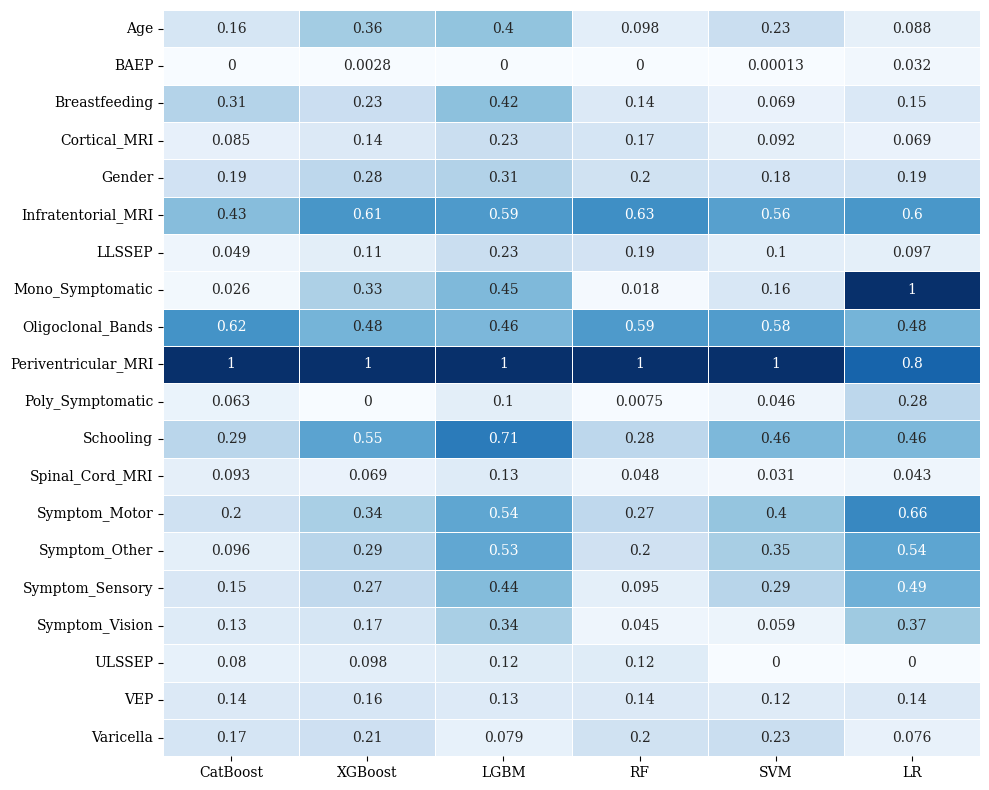

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract the top 5 features for each model
top_features = {}
for model in list(fr.keys())[:-2]:  # Adjust to your actual model list
    top_features[model] = fr[model].sort_values(ascending=True)

# Create a combined DataFrame for the heatmap
heatmap_data = pd.DataFrame(top_features).fillna(0)

# Normalize the feature importance values for better visualization
heatmap_data = (heatmap_data - heatmap_data.min().values) / (heatmap_data.max().values - heatmap_data.min().values)

# idx_list = [index for index in heatmap_data.index if '_MRI' in index or 'Symptom_' in index]
# heatmap_data = heatmap_data.loc[idx_list, :]

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="Blues", linewidths=.5, cbar=False)
plt.ylabel('')

# Save and show the plot
plt.tight_layout()
plt.savefig('../img/feature_importance_heatmap.jpeg', format='jpeg', dpi=600)
plt.show()


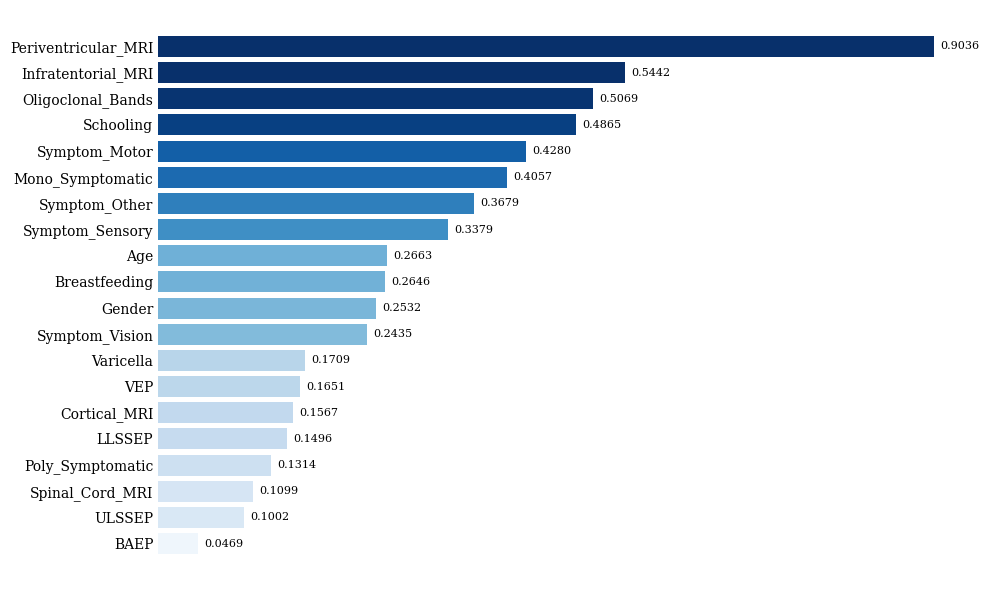

In [6]:
# Sort the DataFrame by the mean_value column in descending order
df_sorted = fr.sort_values('Mean', ascending=True)

# Normalize the values for colormap
norm = plt.Normalize(df_sorted['Mean'].min(), df_sorted['Mean'].max())
cmap = plt.cm.Blues

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(
    df_sorted.index,
    df_sorted['Mean'],
    color=cmap(norm(df_sorted['Mean']*1.75))
)

# Hide top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Hide ticks but keep ticklabels
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.xticks([])

# Add value text to the right of each bar
for i in ax.patches:
    ax.text(i.get_width() + 0.03, i.get_y() + i.get_height() / 2,
            f'{i.get_width():.4f}', ha='center', va='center', fontsize=8, color='black')

# Save the plot
plt.tight_layout()
plt.savefig('../img/feature_ranking.jpeg', format='jpeg', dpi=600)

# Display the plot
plt.show()


In [7]:
auc_cb = metrics['catboost']['roc_auc']
auc_xgb = metrics['xgboost']['roc_auc']
auc_lgbm = metrics['lgbm']['roc_auc']
auc_rf = metrics['rf']['roc_auc']
auc_svm = metrics['svm']['roc_auc']
auc_lr = metrics['lr']['roc_auc']

auc_scores = {model_name: metrics[model_name]['roc_auc'] for model_name in MODEL_NAMES}

In [8]:
# Get predictions for each model
y_preds = {}
y_preds_proba = {}

for mdl_name in MODEL_NAMES:
    y_pred_model = []
    y_pred_proba_model = []

    for fold in range(5):
        mdl = models[mdl_name][fold]
        y_pred_model.extend(mdl.predict(X_val_list[fold]))
        y_pred_proba_model.extend(mdl.predict_proba(X_val_list[fold])[:, 1])

    y_preds[mdl_name] = y_pred_model
    y_preds_proba[mdl_name] = y_pred_proba_model

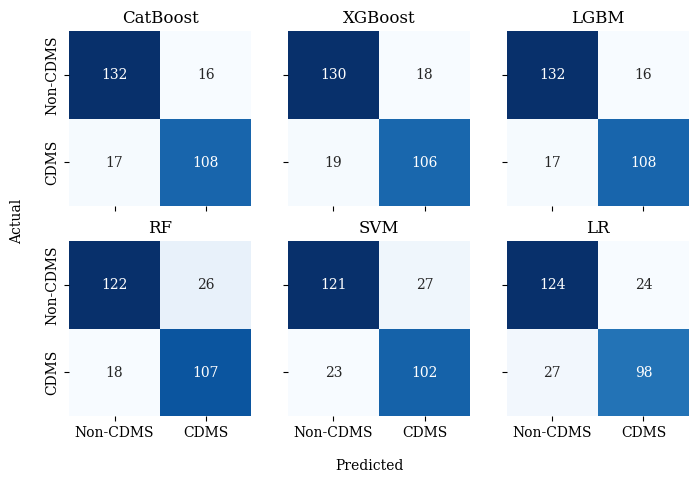

In [9]:
# Plot confusion matrices for each models on validation set
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(2, 3, figsize=(8,5), sharex=True, sharey=True)
labels = ['Non-CDMS', 'CDMS']

# Iterate through each model
for i, mdl_name in enumerate(MODEL_NAMES):
    y_pred_model = y_preds[mdl_name]
    cm = confusion_matrix(y_val_agg, y_pred_model)

    # Plot confusion matrix
    ax = axes.flat[i]
    is_cbar = True if i in [2,5] else False
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False, ax=ax)
    ax.set_title(titles[i])

# Add a single xlabel and ylabel for the entire figure
fig.text(0.5, 0.01, 'Predicted', ha='center', va='center')
fig.text(0.06, 0.5, 'Actual', ha='center', va='center', rotation='vertical')

plt.savefig('../img/confusion_matrices.jpeg', format='jpeg', dpi=600)
plt.show()


In [10]:
metrics

{'catboost': {'accuracy': 0.8791208791208791,
  'roc_auc': 0.9311891891891892,
  'f1_score': 0.8674698795180723,
  'mse': 0.10454457289184921,
  'precision': 0.8709677419354839,
  'recall': 0.864,
  'specificity': 0.8918918918918919},
 'xgboost': {'accuracy': 0.8644688644688645,
  'roc_auc': 0.9202162162162162,
  'f1_score': 0.8514056224899599,
  'mse': 0.1120826908077335,
  'precision': 0.8548387096774194,
  'recall': 0.848,
  'specificity': 0.8783783783783784},
 'lgbm': {'accuracy': 0.8791208791208791,
  'roc_auc': 0.9150270270270269,
  'f1_score': 0.8674698795180723,
  'mse': 0.11291421876108552,
  'precision': 0.8709677419354839,
  'recall': 0.864,
  'specificity': 0.8918918918918919},
 'rf': {'accuracy': 0.8388278388278388,
  'roc_auc': 0.9096756756756756,
  'f1_score': 0.8294573643410853,
  'mse': 0.13326550716438734,
  'precision': 0.8045112781954887,
  'recall': 0.856,
  'specificity': 0.8243243243243243},
 'svm': {'accuracy': 0.8168498168498168,
  'roc_auc': 0.8985405405405406

In [11]:
df = pd.DataFrame(metrics).T
df = df[['roc_auc', 'accuracy', 'f1_score', 'precision', 'recall', 'specificity']]
df.index = titles
df.columns = ['AUC', 'ACC', 'F1 Score', 'Precision', 'Recall', 'Specificity']
df = round(df, 4)
df

,AUC,ACC,F1 Score,Precision,Recall,Specificity
CatBoost,0.9312,0.8791,0.8675,0.8710,0.864,0.8919
XGBoost,0.9202,0.8645,0.8514,0.8548,0.848,0.8784
LGBM,0.9150,0.8791,0.8675,0.8710,0.864,0.8919
RF,0.9097,0.8388,0.8295,0.8045,0.856,0.8243
SVM,0.8985,0.8168,0.8031,0.7907,0.816,0.8176
LR,0.8922,0.8132,0.7935,0.8033,0.784,0.8378


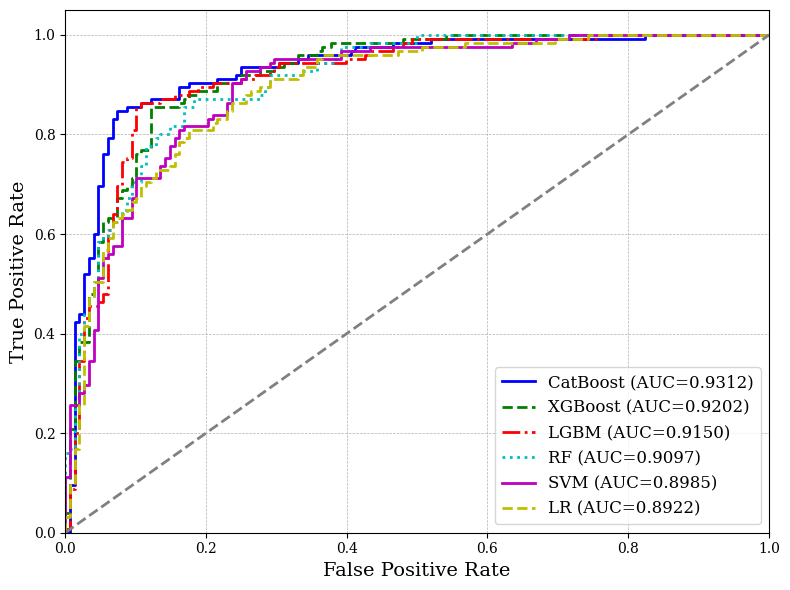

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define a list of colors and line styles for the models
colors = ['b', 'g', 'r', 'c', 'm', 'y']
line_styles = ['-', '--', '-.', ':', '-', '--']

plt.figure(figsize=(8, 6))

for i, mdl_name in enumerate(MODEL_NAMES):
    # Get the predicted probabilities
    y_probs = y_preds_proba[mdl_name]
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_val_agg, y_probs)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve with specified color and line style
    plt.plot(fpr, tpr, color=colors[i], linestyle=line_styles[i], lw=2, label=f'{titles[i]} (AUC={roc_auc:.4f})')

# Plot diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)

# Save and show the plot
plt.tight_layout()
plt.savefig('../img/roc_curves.jpeg', format='jpeg', dpi=600)
plt.show()


In [13]:
# Feature Interaction
shap_interaction_values = load_pickle(paths.get('shap_interaction_values_path'))

In [14]:
import numpy as np
import pandas as pd
from itertools import combinations


# Function to get top interaction pairs
def get_top_interactions(shap_interaction_values, feature_names, top_n=5):
    interaction_results = {}

    for model_name, interaction_values in shap_interaction_values.items():
        # Average the interaction values over all rows (273,20,20) -> (20,20)
        mean_interaction_values = np.mean(np.abs(interaction_values), axis=0)

        # Extract unique pairs by sorting feature names in each pair
        interaction_pairs = []
        interaction_values = []

        for i, j in combinations(range(len(feature_names)), 2):
            f1, f2 = sorted([feature_names[i], feature_names[j]])
            interaction_pairs.append((f1, f2))
            interaction_values.append(mean_interaction_values[i, j])

        # Create DataFrame for unique interactions
        unique_interaction_df = pd.DataFrame(interaction_pairs, columns=['Feature 1', 'Feature 2'])
        unique_interaction_df['Interaction Value'] = interaction_values

        # Sort by interaction value
        unique_interaction_df = unique_interaction_df.sort_values(by='Interaction Value', ascending=False)

        # Get top N interactions
        top_interactions = unique_interaction_df.head(top_n)

        interaction_results[model_name] = top_interactions

    return interaction_results

# Get top interactions
top_interactions = get_top_interactions(shap_interaction_values, feature_names, top_n=5)

# Print top interactions for each model
for model_name, interactions in top_interactions.items():
    print(f"Top interactions for {model_name}:")
    print(interactions)
    print()


Top interactions for catboost:
               Feature 1            Feature 2  Interaction Value
89     Oligoclonal_Bands  Periventricular_MRI           0.097347
9                 Gender  Periventricular_MRI           0.078551
70     Oligoclonal_Bands            Varicella           0.070430
175      Symptom_Sensory       Symptom_Vision           0.067328
125  Periventricular_MRI                  VEP           0.057325

Top interactions for xgboost:
             Feature 1            Feature 2  Interaction Value
89   Oligoclonal_Bands  Periventricular_MRI           0.131877
9               Gender  Periventricular_MRI           0.099022
120      Symptom_Motor               ULSSEP           0.077204
28                 Age         Cortical_MRI           0.069749
182   Mono_Symptomatic      Symptom_Sensory           0.067236

Top interactions for lgbm:
             Feature 1            Feature 2  Interaction Value
120      Symptom_Motor               ULSSEP           0.106938
89   Oligoclonal

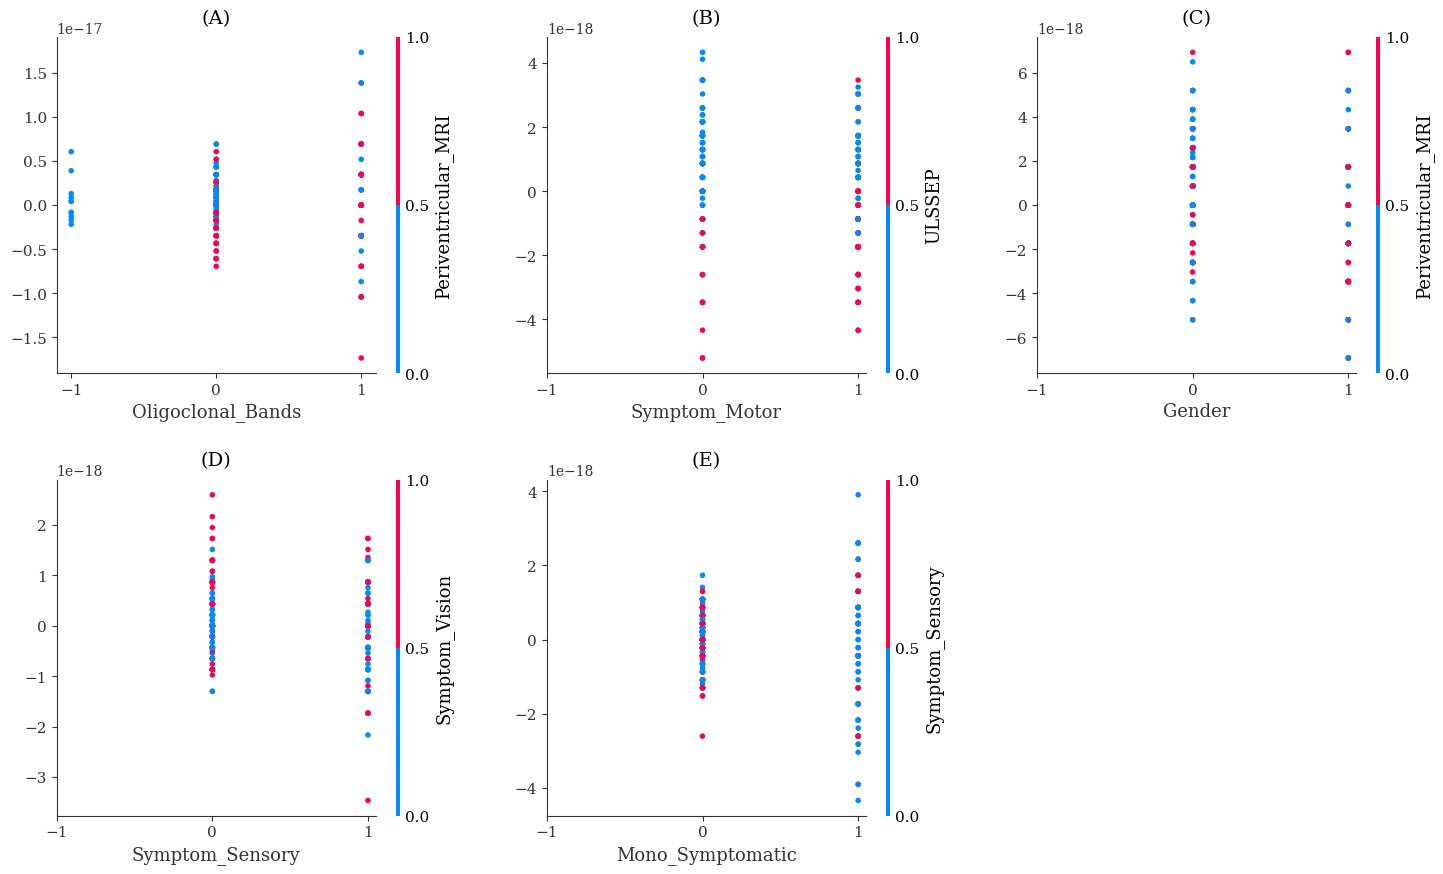

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import shap
import numpy as np

# Assuming top_interactions is a dictionary with model names as keys and DataFrames as values
# Example data for interaction values (replace with actual data)
top_interactions = {
    'catboost': pd.DataFrame({
        'Feature1': ['Oligoclonal_Bands', 'Gender', 'Oligoclonal_Bands', 'Symptom_Sensory', 'Periventricular_MRI'],
        'Feature2': ['Periventricular_MRI', 'Periventricular_MRI', 'Varicella', 'Symptom_Vision', 'VEP'],
        'InteractionValue': [0.097347, 0.078551, 0.070430, 0.067328, 0.057325]
    }),
    'xgboost': pd.DataFrame({
        'Feature1': ['Oligoclonal_Bands', 'Gender', 'Symptom_Motor', 'Age', 'Mono_Symptomatic'],
        'Feature2': ['Periventricular_MRI', 'Periventricular_MRI', 'ULSSEP', 'Cortical_MRI', 'Symptom_Sensory'],
        'InteractionValue': [0.131877, 0.099022, 0.077204, 0.069749, 0.067236]
    }),
    'lgbm': pd.DataFrame({
        'Feature1': ['Symptom_Motor', 'Oligoclonal_Bands', 'Mono_Symptomatic', 'Mono_Symptomatic', 'Breastfeeding'],
        'Feature2': ['ULSSEP', 'Periventricular_MRI', 'Symptom_Sensory', 'Symptom_Vision', 'Mono_Symptomatic'],
        'InteractionValue': [0.106938, 0.063874, 0.062791, 0.062664, 0.058049]
    }),
    'rf': pd.DataFrame({
        'Feature1': ['Infratentorial_MRI', 'Oligoclonal_Bands', 'Age', 'Oligoclonal_Bands', 'Periventricular_MRI'],
        'Feature2': ['Periventricular_MRI', 'Periventricular_MRI', 'Periventricular_MRI', 'Varicella', 'Symptom_Other'],
        'InteractionValue': [1.630076e-18, 1.373075e-18, 1.276320e-18, 1.136625e-18, 1.100876e-18]
    })
}

# Define the pairs to analyze
pairs_to_analyze = [
    ('Oligoclonal_Bands', 'Periventricular_MRI'),
    ('Symptom_Motor', 'ULSSEP'),
    ('Gender', 'Periventricular_MRI'),
    ('Symptom_Sensory', 'Symptom_Vision'),
    ('Mono_Symptomatic', 'Symptom_Sensory')
]

# Calculate sum of interaction values for pairs
interaction_sums = []
for feature1, feature2 in pairs_to_analyze:
    values = []
    for model_name, interactions in top_interactions.items():
        for i, row in interactions.iterrows():
            if (row['Feature1'] == feature1 and row['Feature2'] == feature2) or (row['Feature1'] == feature2 and row['Feature2'] == feature1):
                values.append(row['InteractionValue'])
    sum_value = np.mean(np.abs(values))
    interaction_sums.append({'Feature1': feature1, 'Feature2': feature2, 'SumInteractionValue': sum_value})

interaction_sums_df = pd.DataFrame(interaction_sums)

# Plot dependence plots for each pair
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 9))
axes = axes.flatten()
subplot_titles = ['(A)', '(B)', '(C)', '(D)', '(E)']

for i, (feature1, feature2) in enumerate(pairs_to_analyze):
    plt.sca(axes[i])  # Set the current axis
    shap.dependence_plot((feature1, feature2), shap_interaction_values[model_name], X_val_agg, show=False, ax=axes[i])
    sum_interaction_value = interaction_sums_df[(interaction_sums_df['Feature1'] == feature1) & (interaction_sums_df['Feature2'] == feature2)]['SumInteractionValue'].values[0]
    axes[i].set_title(subplot_titles[i], fontsize=14, pad=10)
    axes[i].set_xlabel(feature1)
    axes[i].set_ylabel('')
    axes[i].set_xticks([-1, 0, 1])

# Remove the empty subplot if there is any
if len(pairs_to_analyze) < len(axes):
    fig.delaxes(axes[-1])

plt.subplots_adjust(wspace=5)

fig.tight_layout()
fig.savefig('../img/interaction_pairs.jpeg', format='jpeg', dpi=600)

<Figure size 640x480 with 0 Axes>

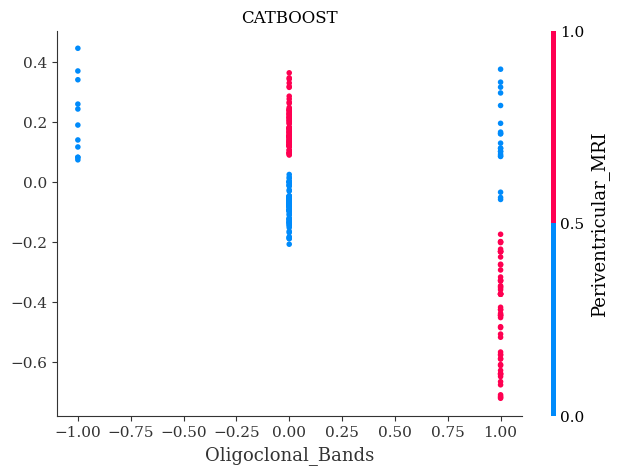

<Figure size 640x480 with 0 Axes>

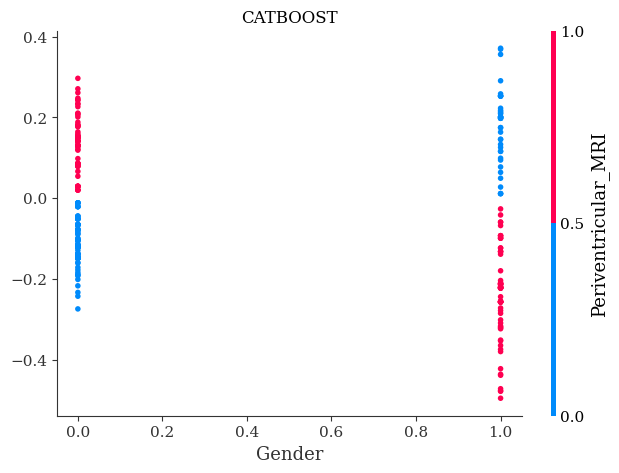

<Figure size 640x480 with 0 Axes>

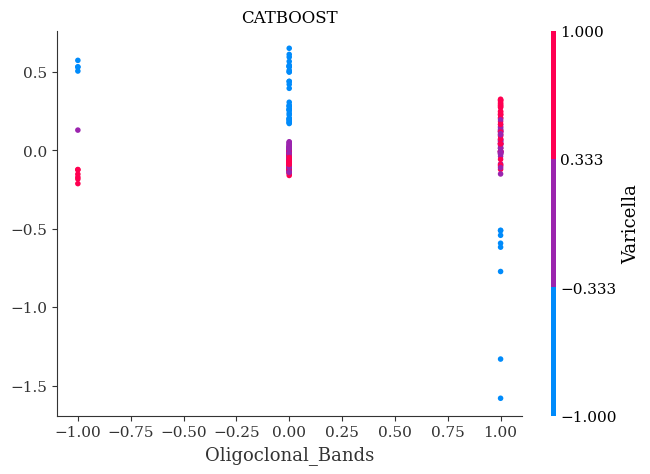

<Figure size 640x480 with 0 Axes>

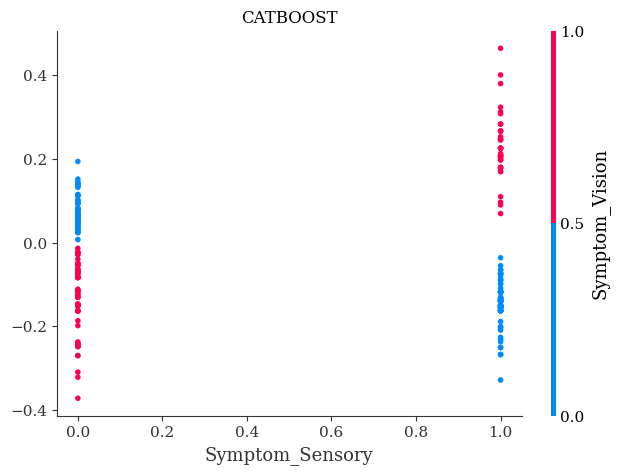

<Figure size 640x480 with 0 Axes>

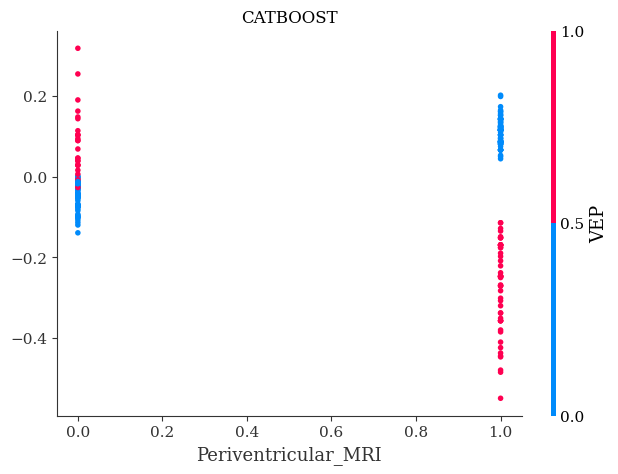

<Figure size 640x480 with 0 Axes>

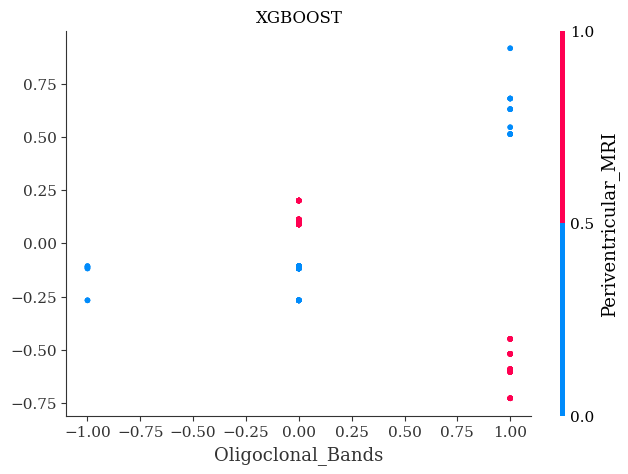

<Figure size 640x480 with 0 Axes>

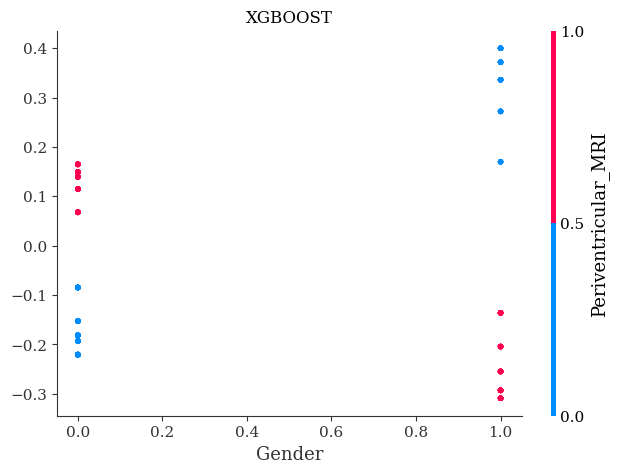

<Figure size 640x480 with 0 Axes>

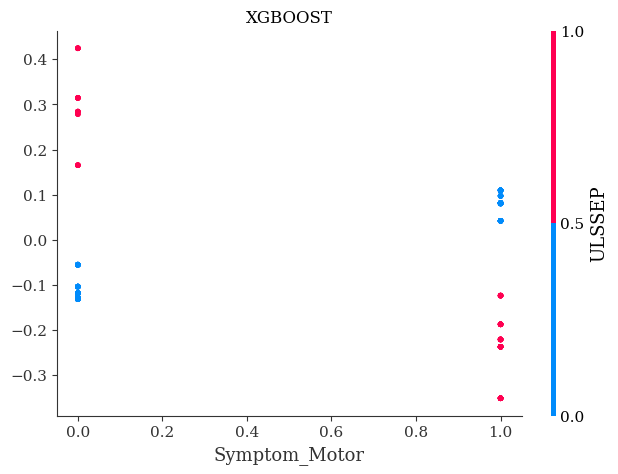

<Figure size 640x480 with 0 Axes>

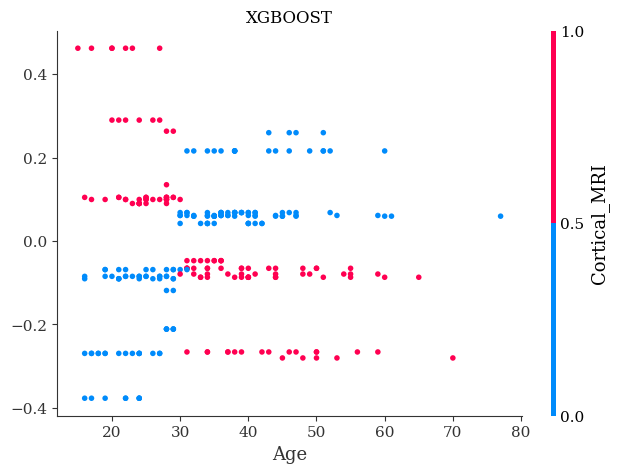

<Figure size 640x480 with 0 Axes>

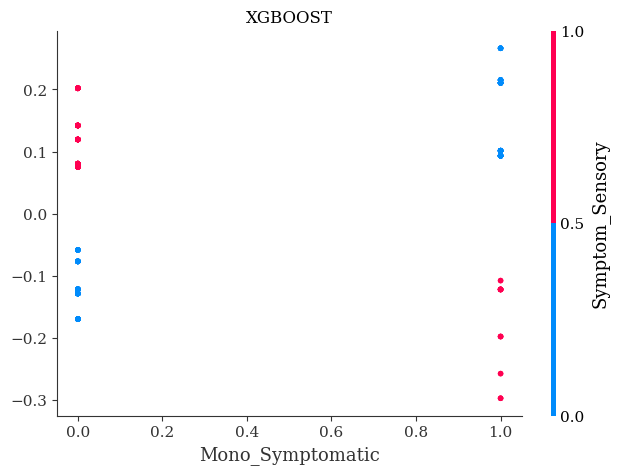

<Figure size 640x480 with 0 Axes>

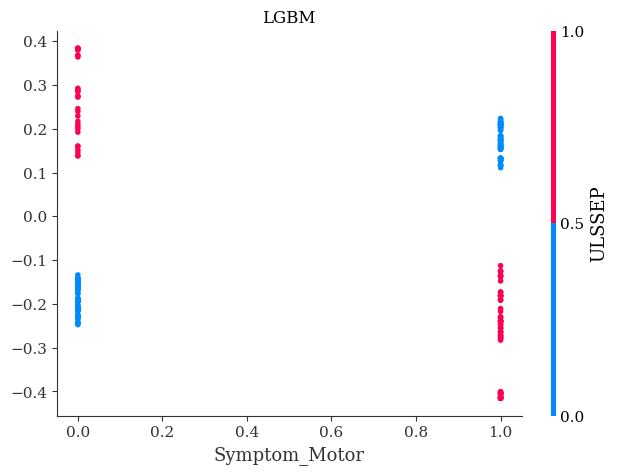

<Figure size 640x480 with 0 Axes>

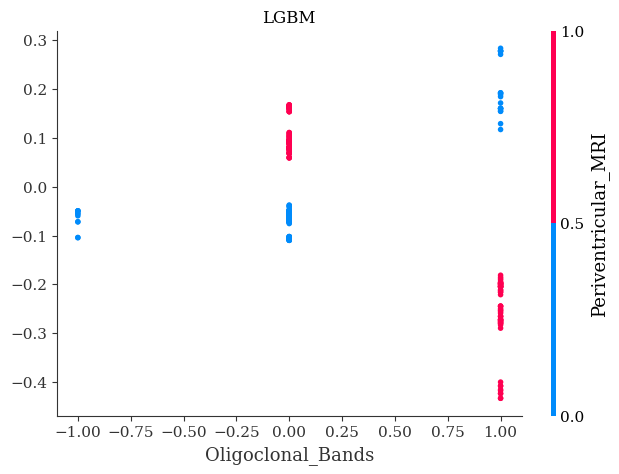

<Figure size 640x480 with 0 Axes>

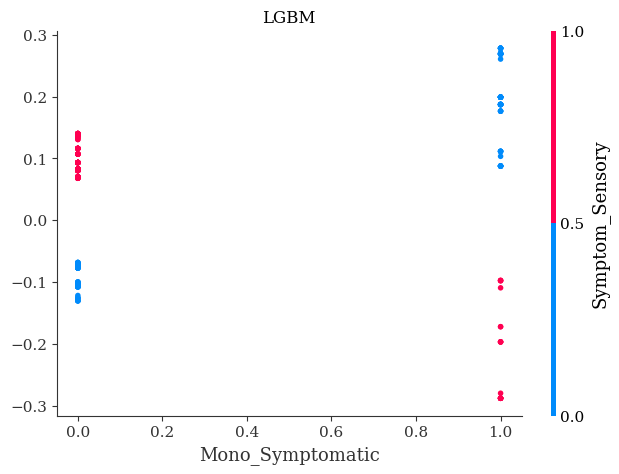

<Figure size 640x480 with 0 Axes>

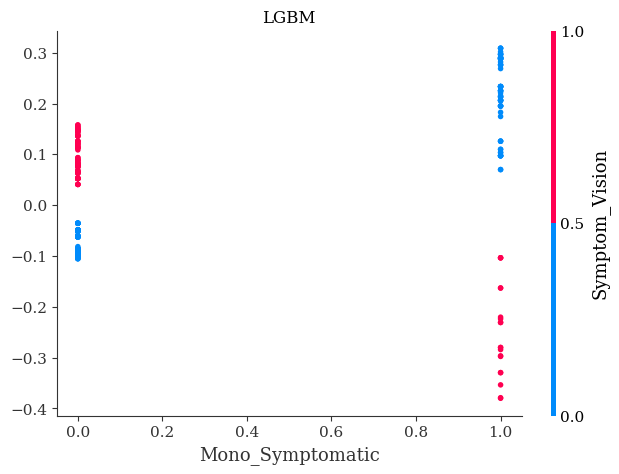

<Figure size 640x480 with 0 Axes>

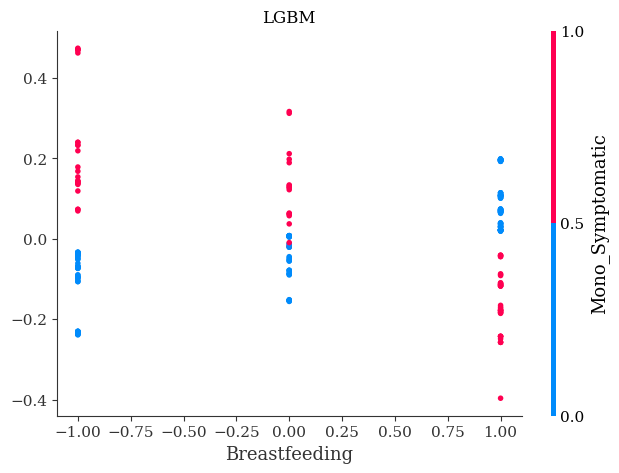

<Figure size 640x480 with 0 Axes>

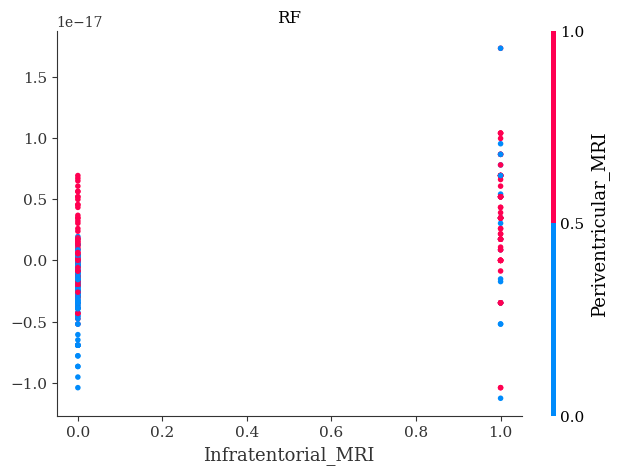

<Figure size 640x480 with 0 Axes>

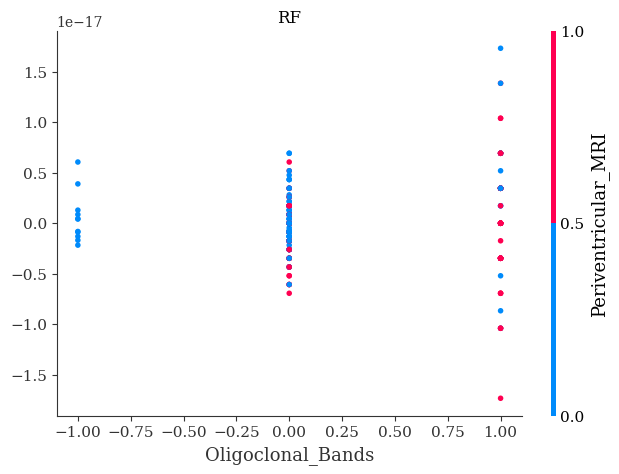

<Figure size 640x480 with 0 Axes>

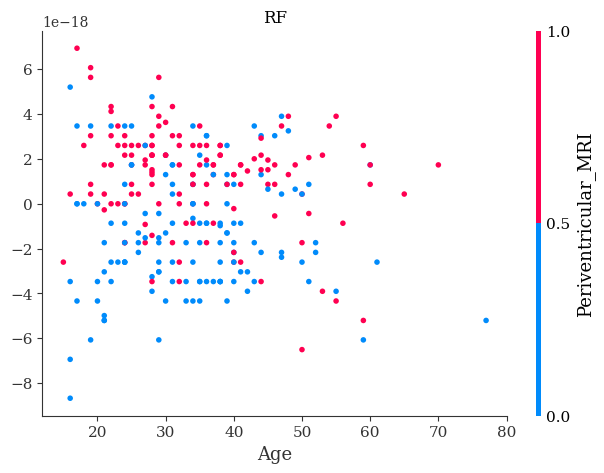

<Figure size 640x480 with 0 Axes>

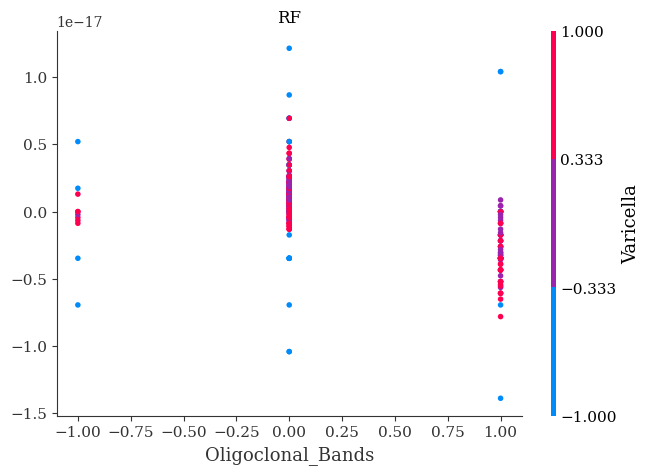

<Figure size 640x480 with 0 Axes>

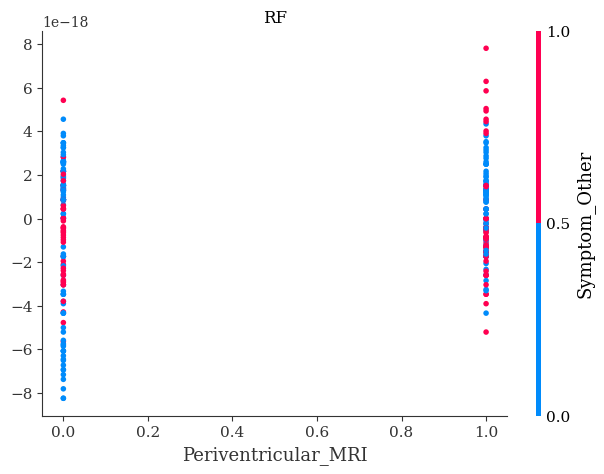

In [16]:
import shap
import matplotlib.pyplot as plt

# Assuming top_interactions is a dictionary with model names as keys and DataFrames as values
top_interactions = {
    'catboost': pd.DataFrame({
        'Feature1': ['Oligoclonal_Bands', 'Gender', 'Oligoclonal_Bands', 'Symptom_Sensory', 'Periventricular_MRI'],
        'Feature2': ['Periventricular_MRI', 'Periventricular_MRI', 'Varicella', 'Symptom_Vision', 'VEP'],
        'InteractionValue': [0.097347, 0.078551, 0.070430, 0.067328, 0.057325]
    }),
    'xgboost': pd.DataFrame({
        'Feature1': ['Oligoclonal_Bands', 'Gender', 'Symptom_Motor', 'Age', 'Mono_Symptomatic'],
        'Feature2': ['Periventricular_MRI', 'Periventricular_MRI', 'ULSSEP', 'Cortical_MRI', 'Symptom_Sensory'],
        'InteractionValue': [0.131877, 0.099022, 0.077204, 0.069749, 0.067236]
    }),
    'lgbm': pd.DataFrame({
        'Feature1': ['Symptom_Motor', 'Oligoclonal_Bands', 'Mono_Symptomatic', 'Mono_Symptomatic', 'Breastfeeding'],
        'Feature2': ['ULSSEP', 'Periventricular_MRI', 'Symptom_Sensory', 'Symptom_Vision', 'Mono_Symptomatic'],
        'InteractionValue': [0.106938, 0.063874, 0.062791, 0.062664, 0.058049]
    }),
    'rf': pd.DataFrame({
        'Feature1': ['Infratentorial_MRI', 'Oligoclonal_Bands', 'Age', 'Oligoclonal_Bands', 'Periventricular_MRI'],
        'Feature2': ['Periventricular_MRI', 'Periventricular_MRI', 'Periventricular_MRI', 'Varicella', 'Symptom_Other'],
        'InteractionValue': [1.630076e-18, 1.373075e-18, 1.276320e-18, 1.136625e-18, 1.100876e-18]
    })
}

# Function to plot dependence plot with a title
def plot_dependence_with_title(model_name, feature1, feature2, shap_interaction_values, X_val, title):
    plt.figure()  # Create a new figure
    shap.dependence_plot((feature1, feature2), shap_interaction_values, X_val, show=False)
    plt.ylabel('')
    plt.title(title)  # Add title
    plt.show()  # Display the plot

# Plot dependence plots for pairs that are in the top interactions of each model
for model_name, interactions in top_interactions.items():
    for i, row in interactions.iterrows():
        feature1 = row['Feature1']
        feature2 = row['Feature2']
        title = model_name.upper()
        plot_dependence_with_title(model_name, feature1, feature2, shap_interaction_values[model_name], X_val_agg, title)


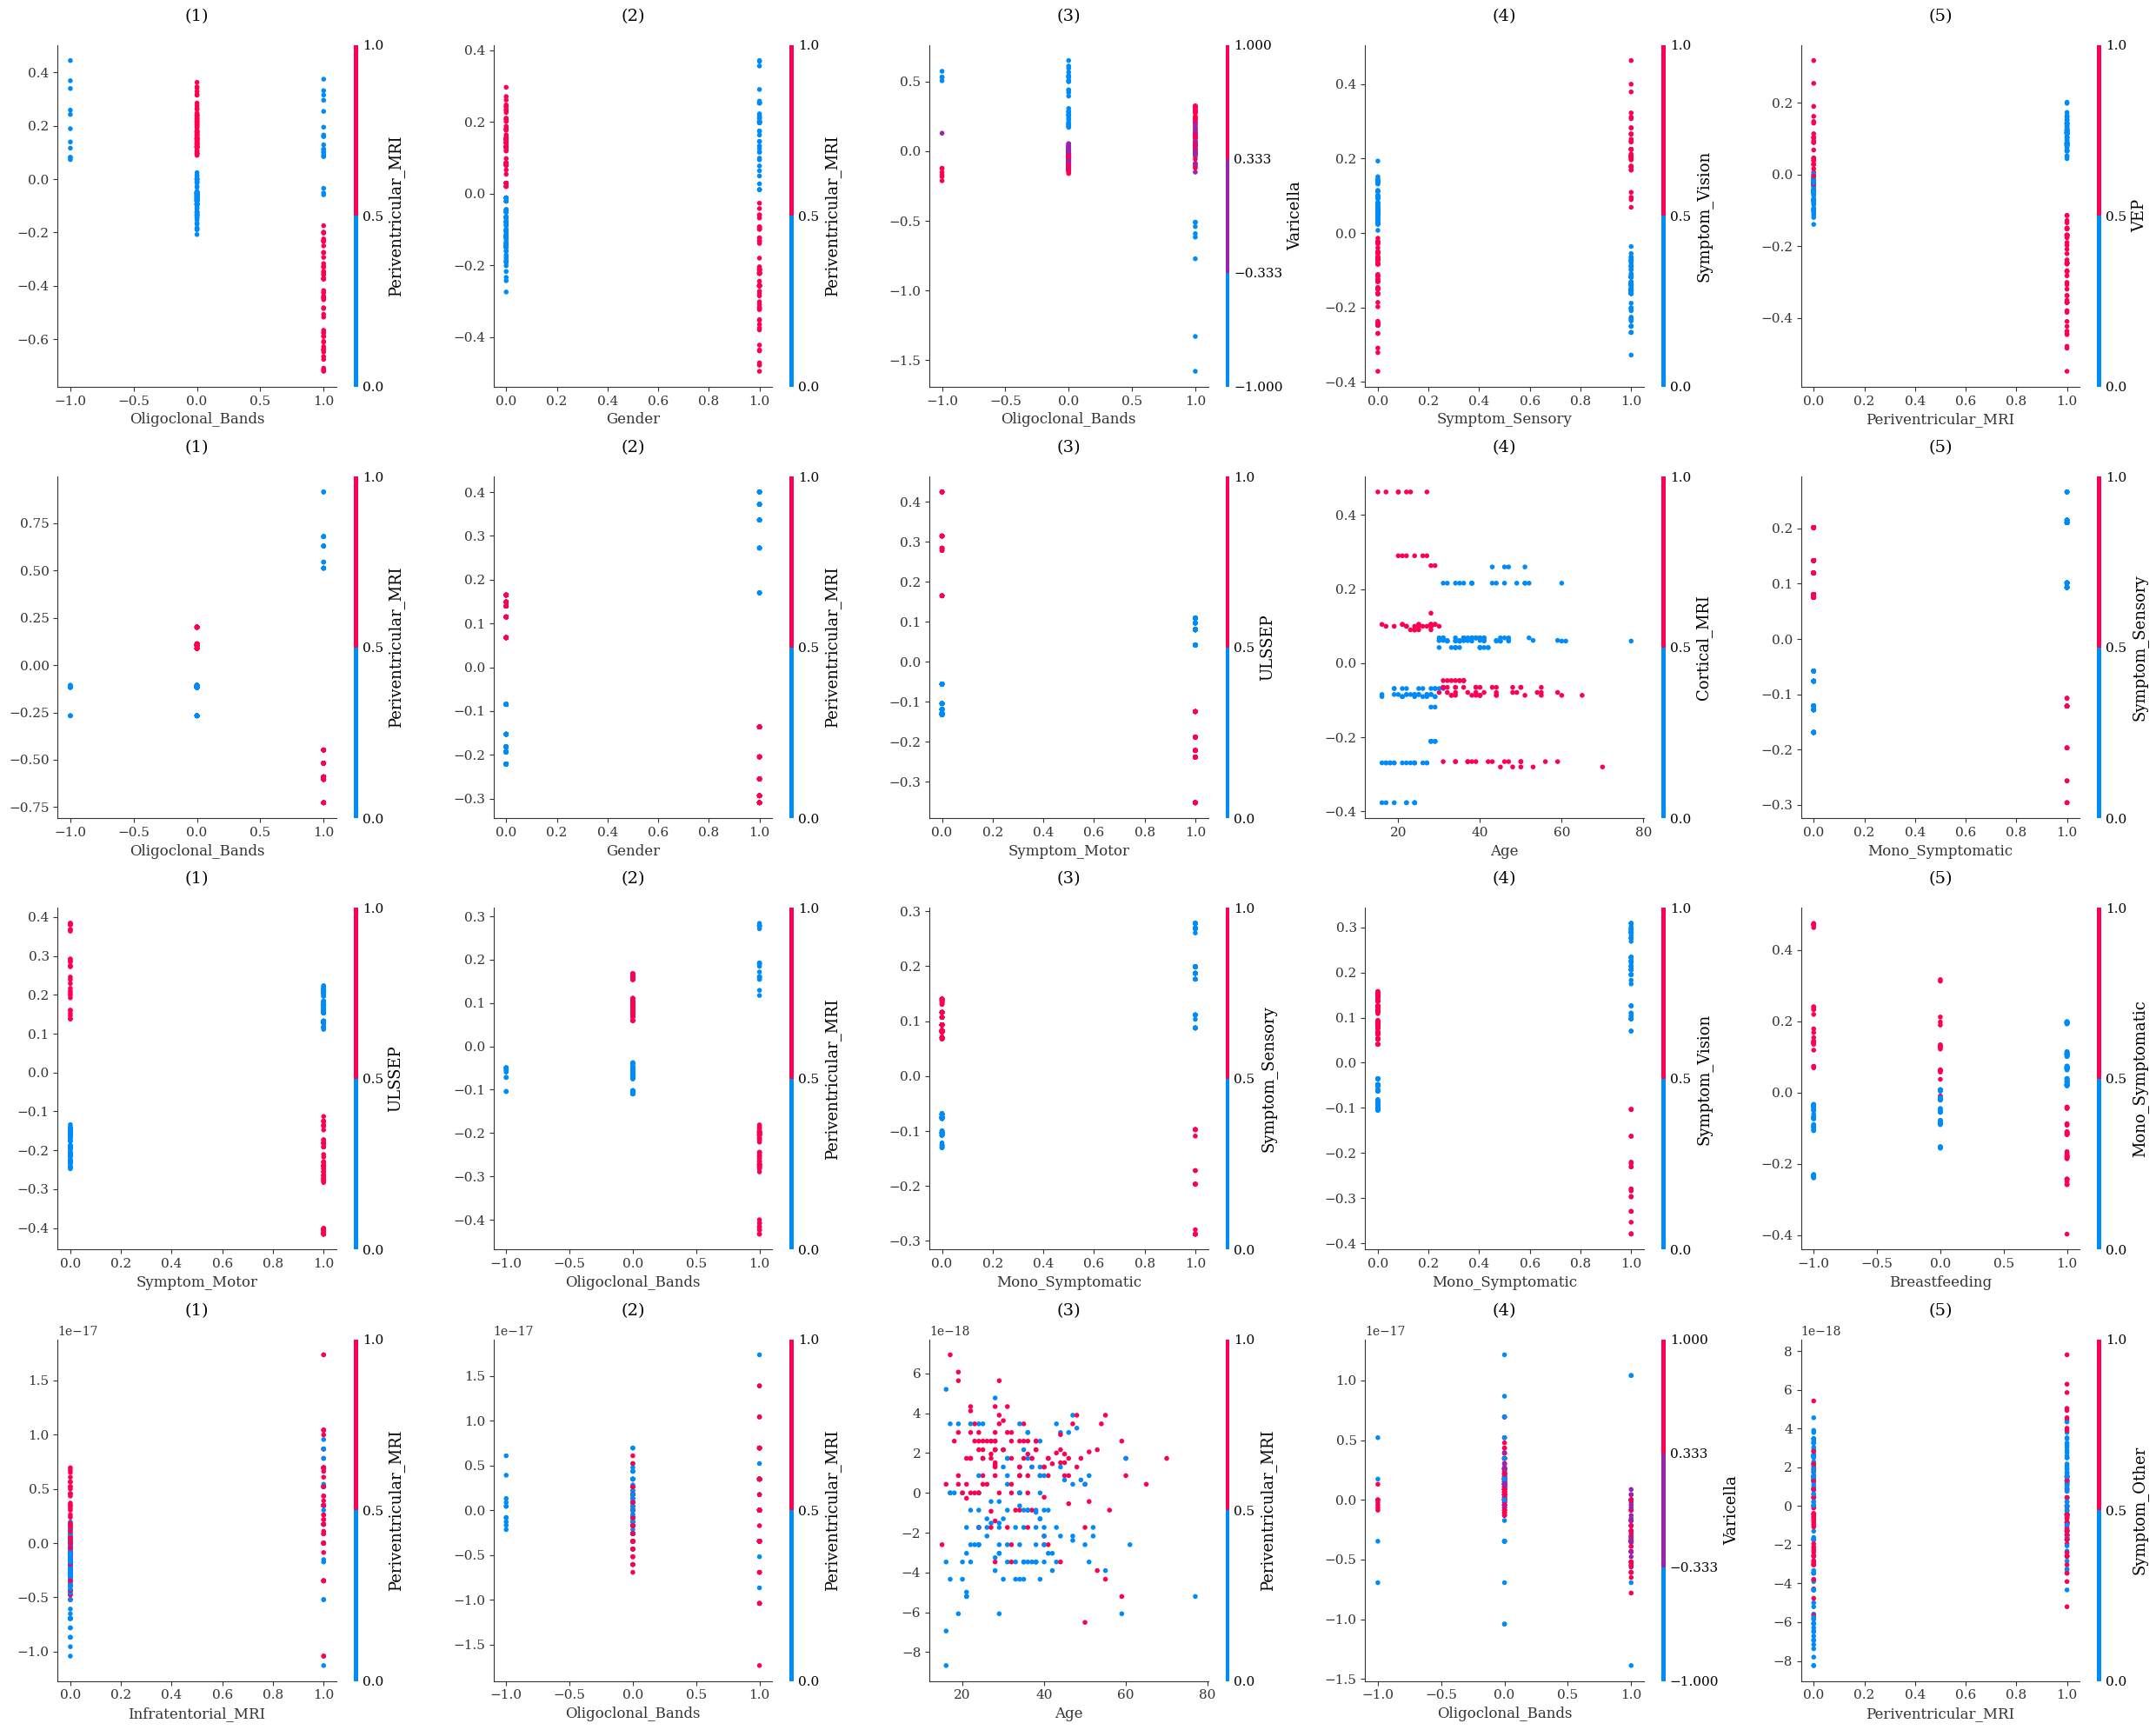

In [17]:
import shap
import matplotlib.pyplot as plt
import pandas as pd


top_interactions = {
    'catboost': pd.DataFrame({
        'Feature1': ['Oligoclonal_Bands', 'Gender', 'Oligoclonal_Bands', 'Symptom_Sensory', 'Periventricular_MRI'],
        'Feature2': ['Periventricular_MRI', 'Periventricular_MRI', 'Varicella', 'Symptom_Vision', 'VEP'],
        'InteractionValue': [0.097347, 0.078551, 0.070430, 0.067328, 0.057325]
    }),
    'xgboost': pd.DataFrame({
        'Feature1': ['Oligoclonal_Bands', 'Gender', 'Symptom_Motor', 'Age', 'Mono_Symptomatic'],
        'Feature2': ['Periventricular_MRI', 'Periventricular_MRI', 'ULSSEP', 'Cortical_MRI', 'Symptom_Sensory'],
        'InteractionValue': [0.131877, 0.099022, 0.077204, 0.069749, 0.067236]
    }),
    'lgbm': pd.DataFrame({
        'Feature1': ['Symptom_Motor', 'Oligoclonal_Bands', 'Mono_Symptomatic', 'Mono_Symptomatic', 'Breastfeeding'],
        'Feature2': ['ULSSEP', 'Periventricular_MRI', 'Symptom_Sensory', 'Symptom_Vision', 'Mono_Symptomatic'],
        'InteractionValue': [0.106938, 0.063874, 0.062791, 0.062664, 0.058049]
    }),
    'rf': pd.DataFrame({
        'Feature1': ['Infratentorial_MRI', 'Oligoclonal_Bands', 'Age', 'Oligoclonal_Bands', 'Periventricular_MRI'],
        'Feature2': ['Periventricular_MRI', 'Periventricular_MRI', 'Periventricular_MRI', 'Varicella', 'Symptom_Other'],
        'InteractionValue': [1.630076e-18, 1.373075e-18, 1.276320e-18, 1.136625e-18, 1.100876e-18]
    })
}

# Create subplots
fig, axes = plt.subplots(4, 5, figsize=(25, 20))  # Adjust the figure size as needed
axes = axes.flatten()

model_names = ['catboost', 'xgboost', 'lgbm', 'rf']
subplot_titles = [f'({i+1})' for i in range(20)]

index = 0
for model_name in model_names:
    features_to_plot = top_interactions[model_name]
    for i, (feature1, feature2) in enumerate(zip(features_to_plot['Feature1'], features_to_plot['Feature2'])):
        plt.sca(axes[index])  # Set the current axis
        shap.dependence_plot((feature1, feature2), shap_interaction_values[model_name], X_val_agg, show=False, ax=axes[index])
        axes[index].set_title(subplot_titles[i], fontsize=14, pad=20)
        axes[index].set_xlabel(feature1, fontsize=12)
        axes[index].set_ylabel('')
        index += 1

# Hide the last empty axes
for j in range(index, len(axes)):
    axes[j].set_visible(False)

# Adjust layout
fig.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/home/luu/CIStoCDMS/notebooks/img/pair_oli_vent.jpeg'

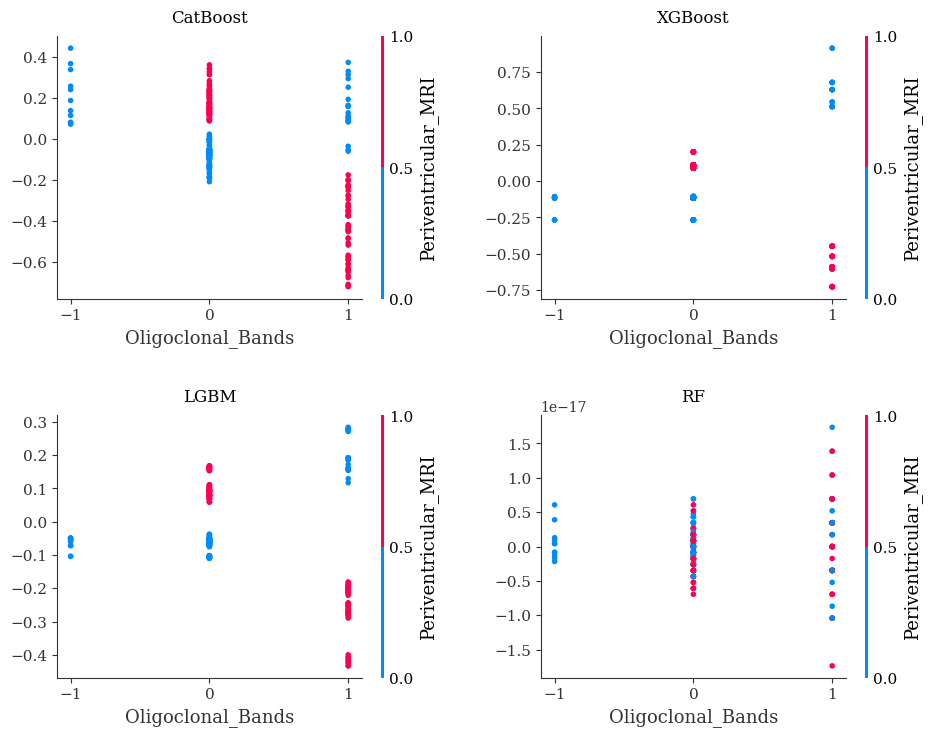

In [18]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Assuming shap_interaction_values is a dictionary with model names as keys and SHAP interaction values as values
# Assuming X_val_agg is the validation data for which SHAP values are calculated

# List of models to plot
models_to_plot = ['catboost', 'xgboost', 'lgbm', 'rf']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
axes = axes.flatten()
subplot_titles = ['CatBoost', 'XGBoost', 'LGBM', 'RF']

# Plot the interaction for each model
for i, model_name in enumerate(models_to_plot):
    plt.sca(axes[i])  # Set the current axis
    shap.dependence_plot(('Oligoclonal_Bands', 'Periventricular_MRI'), shap_interaction_values[model_name], X_val_agg, show=False, ax=axes[i])
    axes[i].set_title(f'{subplot_titles[i]}', pad=10)
    axes[i].set_xlabel('Oligoclonal_Bands')
    axes[i].set_ylabel('')
    axes[i].set_xticks([-1,0,1])

# Adjust layout
fig.tight_layout(pad=3)
fig.savefig('img/pair_oli_vent.jpeg', format='jpeg', dpi=600)

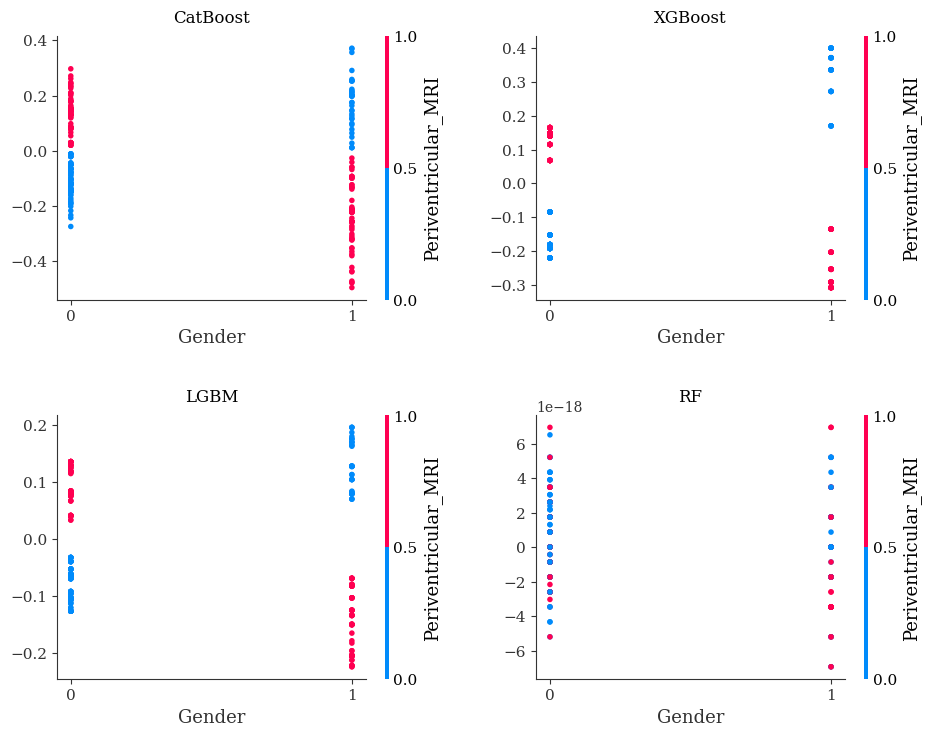

In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Assuming shap_interaction_values is a dictionary with model names as keys and SHAP interaction values as values
# Assuming X_val_agg is the validation data for which SHAP values are calculated

# List of models to plot
models_to_plot = ['catboost', 'xgboost', 'lgbm', 'rf']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
axes = axes.flatten()
subplot_titles = ['CatBoost', 'XGBoost', 'LGBM', 'RF']

# Plot the interaction for each model
for i, model_name in enumerate(models_to_plot):
    plt.sca(axes[i])  # Set the current axis
    shap.dependence_plot(('Gender', 'Periventricular_MRI'), shap_interaction_values[model_name], X_val_agg, show=False, ax=axes[i])
    axes[i].set_title(f'{subplot_titles[i]}', pad=10)
    axes[i].set_xlabel('Gender')
    axes[i].set_ylabel('')
    axes[i].set_xticks([0,1])

# Adjust layout
fig.tight_layout(pad=3)
fig.savefig('../img/pair_gender_vent.jpeg', format='jpeg', dpi=600)


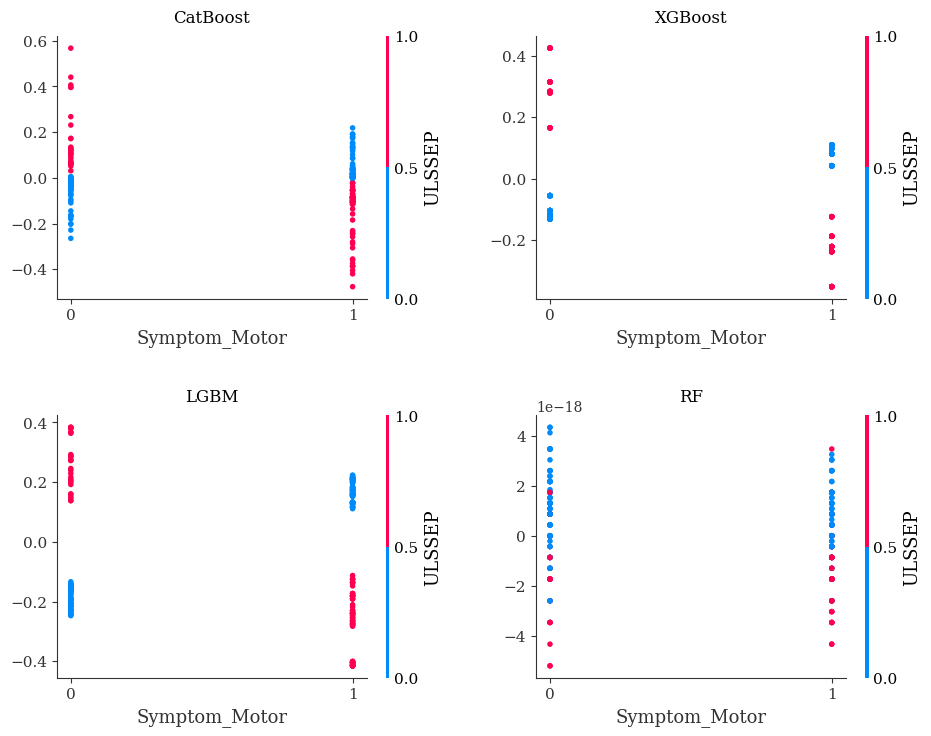

In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Assuming shap_interaction_values is a dictionary with model names as keys and SHAP interaction values as values
# Assuming X_val_agg is the validation data for which SHAP values are calculated

# List of models to plot
models_to_plot = ['catboost', 'xgboost', 'lgbm', 'rf']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
axes = axes.flatten()
subplot_titles = ['CatBoost', 'XGBoost', 'LGBM', 'RF']

# Plot the interaction for each model
for i, model_name in enumerate(models_to_plot):
    plt.sca(axes[i])  # Set the current axis
    shap.dependence_plot(('Symptom_Motor', 'ULSSEP'), shap_interaction_values[model_name], X_val_agg, show=False, ax=axes[i])
    axes[i].set_title(f'{subplot_titles[i]}', pad=10)
    axes[i].set_xlabel('Symptom_Motor')
    axes[i].set_ylabel('')
    axes[i].set_xticks([0,1])

# Adjust layout
fig.tight_layout(pad=3)
fig.savefig('../img/pair_motor_ulssep.jpeg', format='jpeg', dpi=600)
